# Imports

In [3]:
import os, sys, time, glob, random, argparse
import wandb
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import TinyNetwork
from xautodl.models.cell_searchs.genotypes import Structure
from ZeroShotProxy import *
from tss_utils import compute_vkdnw, plot_stats, get_stats, get_metrics, analyze_results, generate_accs, get_results_from_api

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

target = 'val_accs'

# Fisher matrix size

- how does metrics evolve with changing params_grad_len
- data: ImageNet16-120 with batch size 32
- wandb runs: ImageNet16-120_B32_params_grad_len_X

In [5]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120')

In [7]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, params_grad_len in {
    'nazderaze/VKDNW/hqc53sey': 8,
    'nazderaze/VKDNW/kkyfzf21': 16,
    'nazderaze/VKDNW/3bzcrn0t': 32, # compute time 45m 21s
    'nazderaze/VKDNW/3oj5wxoe': 64, # compute time 52m 39s
    'nazderaze/VKDNW/m29ccmi0': 128, # compute time 56m 57s
    'nazderaze/VKDNW/y9ib6om2': 256, # compute time 1h 3m 7s
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['params_grad_len'] = params_grad_len
    run = pd.merge(accs, run, on='arch', how='inner')
    print(f'Fisher matrix size: {params_grad_len}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Fisher matrix size: 8. No. of archs after filtering 1906.
Fisher matrix size: 16. No. of archs after filtering 1816.
Fisher matrix size: 32. No. of archs after filtering 9445.
Fisher matrix size: 64. No. of archs after filtering 9445.
Fisher matrix size: 128. No. of archs after filtering 9445.
Fisher matrix size: 256. No. of archs after filtering 9445.


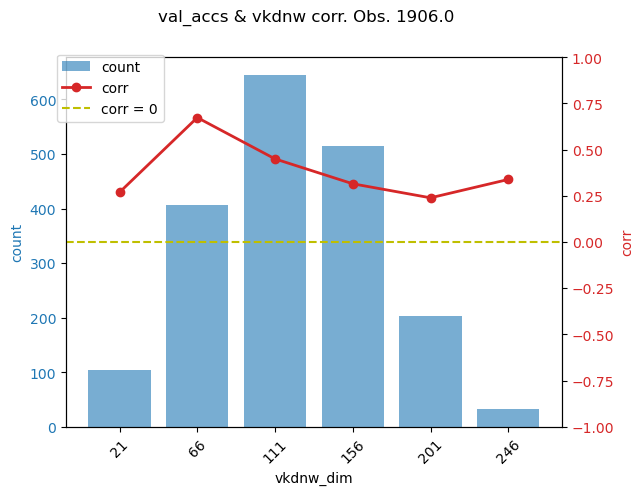

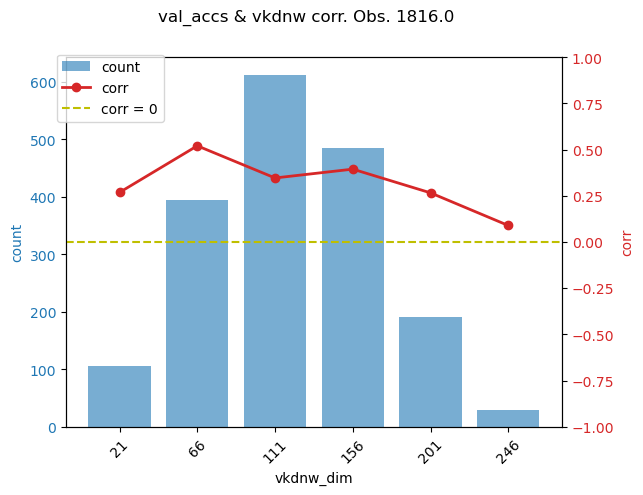

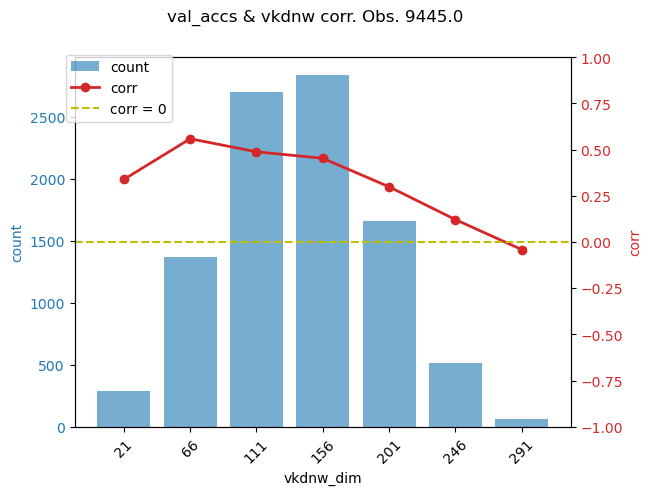

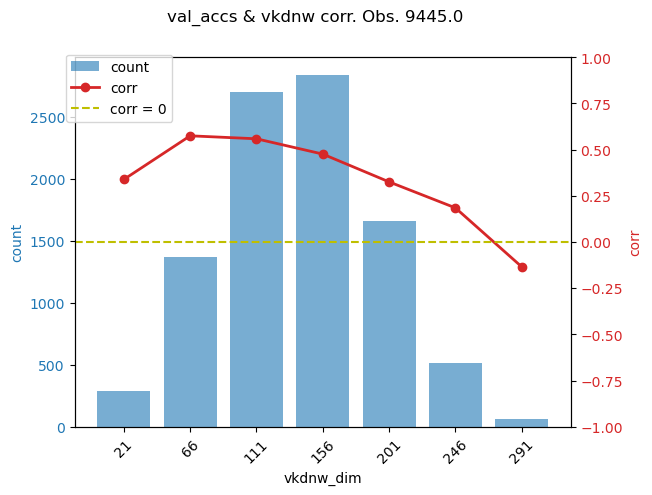

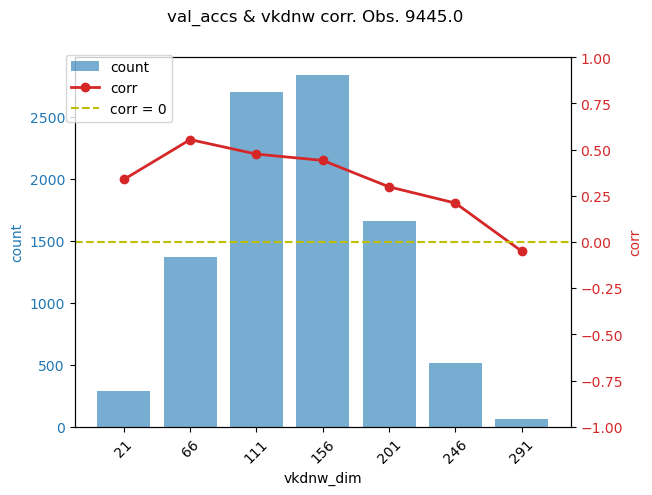

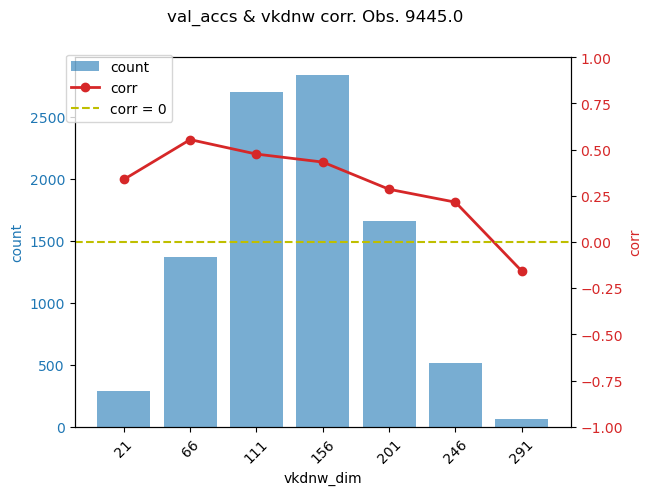

In [8]:
log = None
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_temp = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_temp['params_grad_len'] = params_grad_len
    
    if log is None:
        log = log_temp
    else:
        log = pd.concat([log, log_temp], ignore_index=True)

In [9]:
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,params_grad_len
0,vkdnw,0.672660,0.851724,0.781075,0.575559,0.401245,0.042880,0.976371,0.449788,0.447038,8
1,vkdnw,0.663011,0.846429,0.775986,0.575948,0.401302,0.043008,0.969683,0.438251,0.440706,16
2,vkdnw,0.649957,0.832984,0.756925,0.575469,0.407854,0.043451,0.937561,0.437972,0.441665,32
3,vkdnw,0.659148,0.839057,0.756658,0.575870,0.408206,0.043530,0.934535,0.444159,0.439626,64
4,vkdnw,0.648114,0.830015,0.739769,0.575000,0.407730,0.043550,0.941453,0.450301,0.446952,128
5,vkdnw,0.646909,0.828585,0.738657,0.574895,0.407557,0.043532,0.934713,0.437676,0.440637,256


Fisher matrix size: 8
vkdnw
|skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12677
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=20.99 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.504 & top1 = 90.05%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=20.99 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.312 & top1 = 93.31%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=21.11 ms.
cifar100       train : [loss = 0.059 & top1 = 99.21%], valid : [loss = 1.309 & top1 = 70.85%], test : [loss = 1.326 & top1 = 70.57%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=20.31 ms.
ImageNet16-120 train : [loss = 1.578 & top1 = 57.41%], valid : [loss = 2.162 & top1 = 44.87%], test : [loss = 2.170 & top1 = 45.44%]
vkdnw: 0.67266049803151	0.8517237662024115	0.8517237662024115

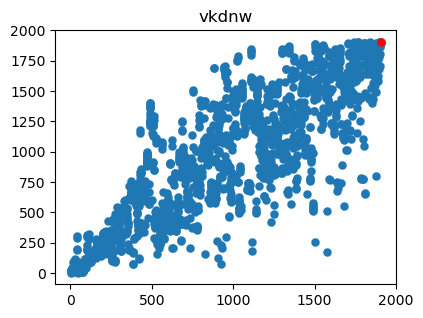

Fisher matrix size: 16
vkdnw
|skip_connect~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=9288
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=21.36 ms.
cifar10-valid  train : [loss = 0.003 & top1 = 99.96%], valid : [loss = 0.493 & top1 = 89.68%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=21.36 ms.
cifar10        train : [loss = 0.005 & top1 = 99.93%], test  : [loss = 0.314 & top1 = 92.94%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=20.54 ms.
cifar100       train : [loss = 0.116 & top1 = 97.80%], valid : [loss = 1.287 & top1 = 69.65%], test : [loss = 1.281 & top1 = 69.95%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=22.63 ms.
ImageNet16-120 train : [loss = 1.743 & top1 = 53.49%], valid : [loss = 2.245 & top1 = 42.51%], test : [loss = 2.228 & top1 = 43.41%]
vkdnw: 0.6630112072291714	0.8464288832304504	0.84642888323045

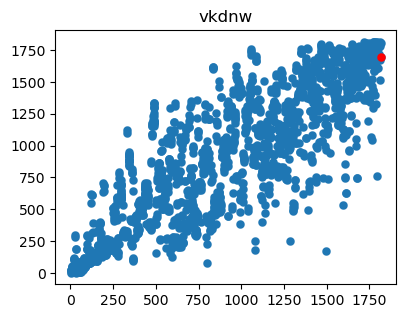

Fisher matrix size: 32
vkdnw
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7294
cifar10-valid  FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.508 & top1 = 89.98%]
cifar10        FLOP=157.21 M, Params=1.101 MB, latency=23.10 ms.
cifar10        train : [loss = 0.003 & top1 = 99.97%], test  : [loss = 0.308 & top1 = 93.42%]
cifar100       FLOP=157.21 M, Params=1.107 MB, latency=23.04 ms.
cifar100       train : [loss = 0.037 & top1 = 99.62%], valid : [loss = 1.320 & top1 = 71.02%], test : [loss = 1.336 & top1 = 71.03%]
ImageNet16-120 FLOP= 39.31 M, Params=1.109 MB, latency=19.37 ms.
ImageNet16-120 train : [loss = 1.857 & top1 = 50.71%], valid : [loss = 2.292 & top1 = 41.10%], test : [loss = 2.292 & top1 = 42.22%]
vkdnw: 0.6499571265397174	0.8329839250376998	0.8329839250377	

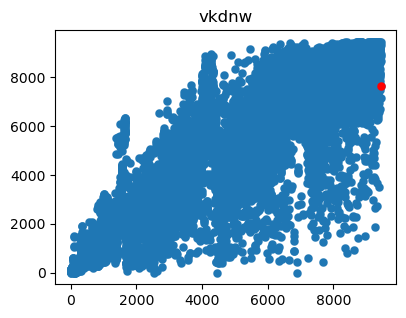

Fisher matrix size: 64
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=7442
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10-valid  train : [loss = 0.003 & top1 = 99.97%], valid : [loss = 0.492 & top1 = 89.85%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=23.12 ms.
cifar10        train : [loss = 0.004 & top1 = 99.94%], test  : [loss = 0.305 & top1 = 93.10%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=21.38 ms.
cifar100       train : [loss = 0.080 & top1 = 98.81%], valid : [loss = 1.276 & top1 = 70.38%], test : [loss = 1.290 & top1 = 70.34%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=21.80 ms.
ImageNet16-120 train : [loss = 1.597 & top1 = 56.99%], valid : [loss = 2.159 & top1 = 44.28%], test : [loss = 2.167 & top1 = 45.24%]
vkdnw: 0.6591479349612106	0.8390568795013581	0.83905687950135

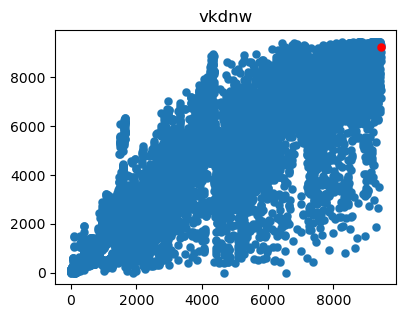

Fisher matrix size: 128
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6481142262918091	0.830015164089027	0.8300151640890

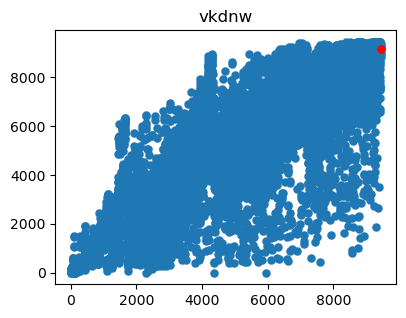

Fisher matrix size: 256
vkdnw
|nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=12598
cifar10-valid  FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.97%], valid : [loss = 0.487 & top1 = 90.30%]
cifar10        FLOP=125.75 M, Params=0.886 MB, latency=21.38 ms.
cifar10        train : [loss = 0.004 & top1 = 99.93%], test  : [loss = 0.308 & top1 = 93.32%]
cifar100       FLOP=125.75 M, Params=0.892 MB, latency=19.63 ms.
cifar100       train : [loss = 0.071 & top1 = 99.00%], valid : [loss = 1.307 & top1 = 70.32%], test : [loss = 1.317 & top1 = 70.02%]
ImageNet16-120 FLOP= 31.44 M, Params=0.894 MB, latency=18.13 ms.
ImageNet16-120 train : [loss = 1.550 & top1 = 58.07%], valid : [loss = 2.128 & top1 = 45.32%], test : [loss = 2.163 & top1 = 44.95%]
vkdnw: 0.6469087665593058	0.828585268188039	0.8285852681880

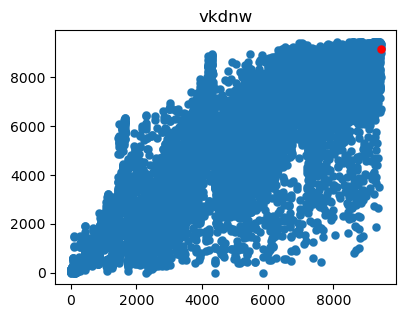

In [10]:
for params_grad_len in [8, 16, 32, 64, 128, 256]:
    results_temp = results.loc[results['params_grad_len']==params_grad_len].copy()
    print(f'Fisher matrix size: {params_grad_len}')
    analyze_results(api_nats, results_temp, 'vkdnw', target)

# Batch size

- how does metrics evolve with changing batch_size
- data: cifar10 with batch size 32 and real input whenever possible
- wandb runs: cifar10_BX_real_input

In [2]:
# Import accs
api_nats = create('/mnt/personal/tyblondr/NATS-tss-v1_0-3ffb9-simple/', 'tss', fast_mode=True, verbose=False)
accs = generate_accs(api_nats, dataset='ImageNet16-120', filter=False)
accs

StopIteration: 

StopIteration: 

In [42]:
import pickle
with open("./tss_all_arch.pickle", "rb") as fp:
    all_archs = pickle.load(fp)
        
api_valid_accs, api_flops, api_params = [], [], []
for a in all_archs:
    try:
        valid_acc, flops, params = get_results_from_api(api_nats, a, 'ImageNet16-120')
        api_valid_accs.append(valid_acc)
        api_flops.append(flops)
        api_params.append(params)
    except Exception as e:
        print(e)
        
accs = pd.DataFrame({
    'arch': [a.tostr() for a in all_archs],
    'val_accs': api_valid_accs,
    'flops': api_flops,
    'params': api_params,
})

In [77]:
# Import data
api_wandb = wandb.Api()

results = None
for run_id, batch_size in {
    #'nazderaze/VKDNW/9d14s94e': 16,
    #'nazderaze/VKDNW/cmic3xuh': 32,
    #'nazderaze/VKDNW/giukshg3': 64,
    #'nazderaze/VKDNW/gvzf6mwl': 128,
    'nazderaze/VKDNW/v8buuof4': 32 #imagenet rand
    #'nazderaze/VKDNW/kwuhsrer': 32 # imagtnet real
}.items():
    run = pd.DataFrame(api_wandb.run(run_id).scan_history())
    run['batch_size'] = batch_size
    run = pd.merge(accs, run, on='arch', how='left')
    print(f'Batch size: {batch_size}. No. of archs after filtering {run.shape[0]}.')
    
    if results is None:
        results = run
    else:
        results = pd.concat([results, run], ignore_index=True)

Batch size: 32. No. of archs after filtering 15625.


In [78]:
for col in results.columns:
    if col != 'arch':
        results[col] = results[col].astype(float)

In [79]:
results.loc[results['jacov'].isnull(), 'jacov'] = results['jacov'].min()

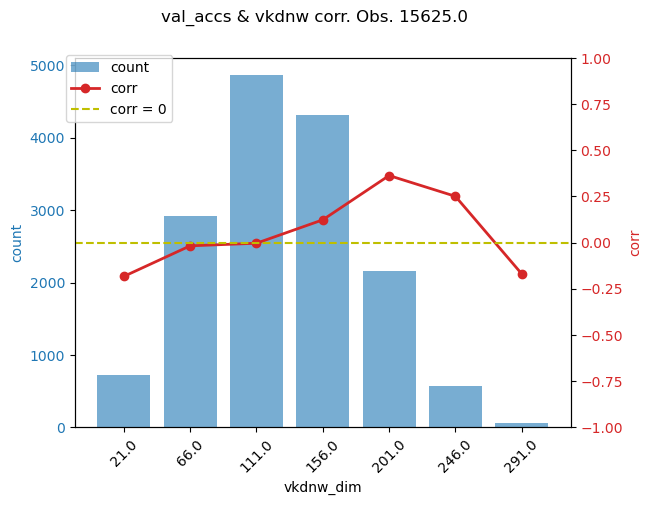

In [80]:
log = None
for batch_size in results['batch_size'].unique():
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    
    results_temp['vkdnw'] = compute_vkdnw(results_temp)
    plot_stats(get_stats(results_temp, 'vkdnw_dim', target, 'vkdnw'), 'vkdnw_dim', target, 'vkdnw')
    log_vkdnw = pd.DataFrame(get_metrics(results_temp, 'vkdnw', show_plot=False))
    log_vkdnw['batch_size'] = batch_size
    
    results_temp['vkdnw_flops'] = results_temp['vkdnw'].rank().apply(np.log) * results_temp['flops'].rank().apply(np.log)
    log_flops = pd.DataFrame(get_metrics(results_temp, 'vkdnw_flops', show_plot=False))
    log_flops['batch_size'] = batch_size
    
    results_temp['vkdnw_exp'] =  results_temp['vkdnw'].rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_exp = pd.DataFrame(get_metrics(results_temp, 'vkdnw_exp', show_plot=False))
    log_exp['batch_size'] = batch_size
    
    results_temp['vkdnw_prog'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_prog = pd.DataFrame(get_metrics(results_temp, 'vkdnw_prog', show_plot=False))
    log_prog['batch_size'] = batch_size
    
    results_temp['vkdnw_trai'] =  results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['vkdnw'].rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)    
    log_trai = pd.DataFrame(get_metrics(results_temp, 'vkdnw_trai', show_plot=False))
    log_trai['batch_size'] = batch_size
    
    results_temp['az_nas'] = results_temp['expressivity'].astype(float).rank().apply(np.log)+results_temp['progressivity'].astype(float).rank().apply(np.log)+results_temp['trainability'].astype(float).rank().apply(np.log)+results_temp['flops'].rank().apply(np.log)
    log_az = pd.DataFrame(get_metrics(results_temp, 'az_nas', show_plot=False))
    log_az['batch_size'] = batch_size
    
    if log is None:
        log = pd.concat([log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
    else:
        log = pd.concat([log, log_vkdnw, log_flops, log_exp, log_prog, log_trai, log_az], ignore_index=True)
        
    for pred_name in ['gradsign', 'zico', 'zen','naswot','synflow','snip','grasp', 'zen', 'jacov']:
        results_temp[pred_name] = results_temp[pred_name].astype(float).rank()
        log_temp = pd.DataFrame(get_metrics(results_temp, pred_name, show_plot=False))
        log_temp['batch_size'] = batch_size
        log = pd.concat([log, log_temp], ignore_index=True)

In [81]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32.0
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32.0
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32.0
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32.0
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32.0
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32.0
6,gradsign,-0.173231,-0.228196,-0.108086,0.486695,0.310728,0.022074,0.342155,0.161128,0.161139,32.0
7,zico,0.602476,0.793496,0.750188,0.592347,0.396218,0.042855,0.919770,0.426090,0.427395,32.0
8,zen,0.260149,0.358017,0.396907,0.548859,0.354905,0.031651,0.784693,0.398590,0.346656,32.0
9,naswot,0.611091,0.792200,0.752459,0.592627,0.395713,0.042646,0.926666,0.396220,0.447590,32.0


In [76]:
# IN real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.515595,0.706100,0.636677,0.578943,0.391376,0.043260,0.931105,0.429002,0.439398,32.0
1,vkdnw_flops,0.540000,0.734071,0.677375,0.580396,0.391063,0.042644,0.916300,0.423507,0.423254,32.0
2,vkdnw_exp,0.610242,0.807044,0.815197,0.593805,0.397027,0.043350,0.947305,0.436001,0.447023,32.0
3,vkdnw_prog,0.660864,0.852287,0.821171,0.596385,0.400014,0.043728,0.947962,0.435771,0.443246,32.0
4,vkdnw_trai,0.556295,0.748022,0.760586,0.586181,0.391491,0.042257,0.919092,0.418304,0.441849,32.0
5,az_nas,0.607677,0.803046,0.835856,0.593955,0.396114,0.042911,0.940787,0.433633,0.441923,32.0
6,gradsign,-0.177431,-0.232116,-0.111808,0.486236,0.309664,0.021206,0.313275,0.146142,0.153826,32.0
7,zico,0.599894,0.792333,0.748645,0.592158,0.396177,0.042872,0.918095,0.425116,0.432898,32.0
8,zen,0.226680,0.316603,0.369193,0.545447,0.352188,0.031487,0.799081,0.393779,0.381852,32.0
9,naswot,0.593334,0.776978,0.737279,0.590759,0.394664,0.042646,0.927265,0.400891,0.446908,32.0


In [45]:
# IN rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.519499,0.708751,0.623443,0.579266,0.391545,0.043254,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.541603,0.734992,0.679512,0.580549,0.391090,0.042643,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.667432,0.859745,0.845288,0.597910,0.400512,0.043717,0.954597,0.440412,0.447207,32
3,vkdnw_prog,0.679080,0.867631,0.845046,0.598112,0.400932,0.043724,0.950947,0.439465,0.445697,32
4,vkdnw_trai,0.630195,0.818701,0.814508,0.592500,0.395378,0.042155,0.906371,0.410229,0.421871,32
5,az_nas,0.671773,0.858802,0.874021,0.598280,0.399595,0.043268,0.947654,0.443887,0.439196,32


In [25]:
# real
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.611147,0.803146,0.758054,0.572503,0.406610,0.043460,0.931105,0.429002,0.439398,32
1,vkdnw_flops,0.615883,0.806525,0.824650,0.572486,0.405637,0.042880,0.916202,0.423446,0.423392,32
2,vkdnw_exp,0.620683,0.812089,0.859026,0.574967,0.407072,0.043798,0.950372,0.437601,0.444191,32
3,vkdnw_prog,0.695918,0.874842,0.884362,0.578658,0.410327,0.044066,0.944587,0.436931,0.445379,32
4,vkdnw_trai,0.580295,0.764877,0.808779,0.569467,0.403002,0.042934,0.922635,0.417245,0.437343,32
5,az_nas,0.592456,0.787018,0.822305,0.572652,0.405563,0.043557,0.941073,0.433381,0.441813,32


In [22]:
# rand
log

,pred_name,kendall,spearman,pearson,auc_roc,auc_pr,auc_pr10,gain_norm,gain_exp,gain_log,batch_size
0,vkdnw,0.646908,0.828585,0.738657,0.574895,0.407554,0.043529,0.931568,0.435225,0.436227,32
1,vkdnw_flops,0.631451,0.816308,0.840885,0.573524,0.405936,0.042817,0.912855,0.415094,0.431138,32
2,vkdnw_exp,0.664144,0.851997,0.875792,0.577418,0.409307,0.044041,0.952766,0.438495,0.450524,32
3,vkdnw_prog,0.703325,0.879728,0.898475,0.579363,0.410573,0.044070,0.950808,0.439424,0.445860,32
4,vkdnw_trai,0.645956,0.825972,0.841372,0.573794,0.405503,0.042530,0.918109,0.411636,0.427104,32
5,az_nas,0.643782,0.835676,0.843053,0.575671,0.408022,0.043750,0.948355,0.443259,0.447419,32


Batch size: 32
expressivity
progressivity
trainability
|nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=6022
cifar10-valid  FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.489 & top1 = 90.16%]
cifar10        FLOP=121.82 M, Params=0.858 MB, latency=20.11 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.301 & top1 = 93.60%]
cifar100       FLOP=121.82 M, Params=0.864 MB, latency=19.01 ms.
cifar100       train : [loss = 0.055 & top1 = 99.33%], valid : [loss = 1.296 & top1 = 70.46%], test : [loss = 1.286 & top1 = 70.77%]
ImageNet16-120 FLOP= 30.46 M, Params=0.866 MB, latency=20.66 ms.
ImageNet16-120 train : [loss = 1.619 & top1 = 56.44%], valid : [loss = 2.163 & top1 = 44.27%], test : [loss = 2.197 & top1 = 44.14%]
AZ-NAS: 0.671772514656878	0.8588018

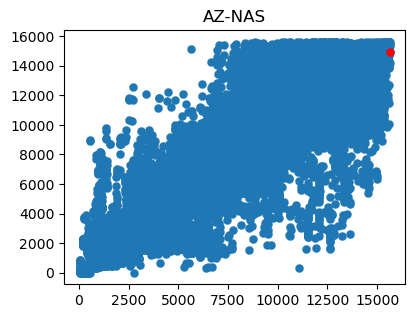

In [83]:
for batch_size in [32]:
    results_temp = results.loc[results['batch_size']==batch_size].copy()
    print(f'Batch size: {batch_size}')
    analyze_results(api_nats, results_temp, 'az_nas', target)

In [10]:
results_temp.head()

,arch,val_accs,flops,params,_timestamp,vkdnw_lambda_1,vkdnw_lambda_2,vkdnw_lambda_6,jacov,vkdnw_lambda_8,...,trainability,grasp,grad_norm,naswot,_runtime,vkdnw_lambda_3,zen,zico,vkdnw_lambda_5,batch_size
0,|avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_...,88.916667,15.64737,0.129306,1.729556e+09,2.627798e-05,8.005195e-05,43.356880,-16.928594,1401.476685,...,-0.155076,1.782674,3.093219,192.557599,48633.014337,0.080949,95.459938,343.456662,7.197623,16
1,|nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~...,93.580000,82.49409,0.587386,1.729552e+09,2.448007e-02,2.796511e+00,1304.875732,-16.112389,71318.585938,...,-0.113689,1.677209,2.473265,198.715157,44518.133664,29.594460,133.148972,544.400148,394.967560,16
2,|skip_connect~0|+|skip_connect~0|none~1|+|nor_...,92.395000,82.49409,0.587386,1.729521e+09,2.290318e-05,1.409506e-04,76.826996,-16.075762,2137.810303,...,-0.106033,5.473819,6.602708,199.223709,13911.850612,0.025663,96.07267,550.793540,19.118641,16
3,|avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_...,90.605000,23.51169,0.185306,1.729555e+09,6.216018e-04,2.108188e-03,13.995205,-16.576809,1570.360352,...,-0.088,54.726673,13.180796,204.200699,47310.691766,0.014016,72.628822,606.687192,1.998187,16
4,|nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|nor_...,92.465000,90.35841,0.643386,1.729531e+09,1.190710e-08,2.478346e-07,1.285074,-16.082071,40.755959,...,-0.146349,4088.751751,80.977608,207.504915,23849.235478,0.000002,103.321503,808.339716,0.283654,16
